<a href="https://colab.research.google.com/github/ArkayNeGG/BigDataUPSO/blob/main/TP1/Grupo15_Laboratorio1_Recup_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Import de librerias, carga de datos y filtrado de datos
from google.colab import drive
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import os

ruta_de_archivos =  "/content/Dataset de ventas2"
archivos = os.listdir(ruta_de_archivos)

dataframes = {}

In [6]:
#Carga de datos
for archivo in archivos:
    if archivo.endswith('.csv'):
        mes = archivo.split('_')[3].split('.')[0]
        ruta_completa = os.path.join(ruta_de_archivos, archivo)
        df = pd.read_csv(ruta_completa)
        dataframes[mes] = df

# Función para limpiar y transformar los datos
def limpiar_y_transformar(datos):
    datos["ID de Pedido"] = pd.to_numeric(datos["ID de Pedido"], errors="coerce")
    datos["Cantidad Pedida"] = pd.to_numeric(datos["Cantidad Pedida"], errors="coerce")
    datos["Precio Unitario"] = pd.to_numeric(datos["Precio Unitario"], errors="coerce")

    datos = datos.loc[~datos["ID de Pedido"].isna()]
    datos = datos.loc[~datos["Cantidad Pedida"].isna()]
    datos = datos.loc[~datos["Precio Unitario"].isna()]

    datos = datos.dropna()

    datos["ID de Pedido"] = datos["ID de Pedido"].astype(int)
    datos["Cantidad Pedida"] = datos["Cantidad Pedida"].astype(int)
    datos["Precio Unitario"] = datos["Precio Unitario"].astype(int)
    datos["Fecha de Pedido"] = pd.to_datetime(datos["Fecha de Pedido"])

    datos["Hora"] = datos["Fecha de Pedido"].dt.hour
    datos["Dia"] = datos["Fecha de Pedido"].dt.day

    direccion_df = datos["Dirección de Envio"].str.split(', ', expand=True)
    direccion_df.columns = ['Calle', 'Ciudad', 'PO BOX']
    direccion_df[['Estado', 'Cod Postal']] = direccion_df['PO BOX'].str.split(' ', expand=True)
    datos = pd.concat([datos, direccion_df], axis=1)

    return datos


In [7]:
# Limpieza y transformación de datos
for key, value in dataframes.items():
    dataframes[key] = limpiar_y_transformar(value)

In [8]:
#Análisis de datos y respuestas a preguntas
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

# Ordenamos las keys del diccionario en el orden de los meses
dictOrdenado = {}
for mes in meses:
  dictOrdenado[mes] = dataframes[mes]
dataframes = dictOrdenado

In [9]:
# Comportamiento de las ventas en los distintos meses
ventasPorMes = []
ingresosPorMes = []

for key in dataframes.keys():
    ventaMes = dataframes[key]["Cantidad Pedida"].sum()
    ventasPorMes.append(ventaMes)
    ingresoMes = (dataframes[key]["Cantidad Pedida"] * dataframes[key]["Precio Unitario"]).sum()
    ingresosPorMes.append(ingresoMes)

# Visualización de las ventas por mes
fig = go.Figure()

fig.add_trace(go.Bar(
    x=meses,
    y=ventasPorMes,
    marker=dict(color=ventasPorMes, colorscale="reds", colorbar=dict(title="Total de Ventas", x=1.0, thickness=15)),
    text=ventasPorMes,
    textposition='auto',
))

fig.update_layout(
    title="Ventas por mes",
    xaxis=dict(title="Mes"),
    yaxis=dict(title="Total de Ventas"),
)

fig.show()

# Visualización de ingresos por mes
fig = go.Figure()

fig.add_trace(go.Bar(
    x=meses,
    y=ingresosPorMes,
    marker=dict(color=ingresosPorMes, colorscale="hot", colorbar=dict(title="Total de Ingresos", x=1.0, thickness=15)),
    text=ingresosPorMes,
    textposition='auto',
))

fig.update_layout(
    title="Ingresos por mes",
    xaxis=dict(title="Mes"),
    yaxis=dict(title="Total de Ingresos"),
)

fig.show()

In [10]:
#Optimización de la publicidad y patrón de ventas por hora
# Análisis de patrones de ventas por hora
ventasXdiaXmes = []

for mes in meses:
    ventasXhora = dataframes[mes].groupby('Hora')['Cantidad Pedida'].sum()
    ventasXdiaXmes.append(ventasXhora)

df = pd.DataFrame(ventasXdiaXmes)

ventasXhora = []
for i in range(0, 24):
    ventasXhora.append(df[i].sum())

Horas = list(range(24))

# Visualización de unidades vendidas por hora
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=Horas,
    y=ventasXhora,
    mode='lines',
    name='Total de unidades vendidas por hora',
    line=dict(width=2, shape='spline'),
))

fig.update_layout(
    title="Total de unidades vendidas por hora",
    xaxis=dict(title="Horas", tickvals=Horas),
    yaxis=dict(title="Unidades vendidas", side="left"),
    legend=dict(y=0.3, yanchor='bottom'),
)

fig.show()

# Visualización de unidades vendidas por hora a lo largo de los meses
fig = go.Figure()
i = 0

for mes in meses:
    fig.add_trace(go.Scatter(
        x=Horas,
        y=ventasXdiaXmes[i],
        mode='lines',
        name=mes,
        line=dict(width=2, shape='spline'),
    ))
    i += 1

fig.update_layout(
    title="Unidades vendidas por hora a lo largo de los meses",
    xaxis=dict(title="Horas", tickvals=Horas),
    yaxis=dict(title="Unidades vendidas", side="left"),
    legend=dict(y=0.3, yanchor='bottom'),
)


fig.show()

In [11]:
fig = go.Figure()

# Definir las horas que se van a analizar
horas_analizadas = [12, 19]

# Iterar a través de las horas en la lista horas_analizadas
for hora in horas_analizadas:
    total_unidades_vendidas = []  # Lista para almacenar el total de unidades vendidas en cada mes

    # Iterar a través de los meses en la lista 'meses'
    for mes in meses:
        # Obtener el DataFrame correspondiente al mes
        dataframe_mes = dataframes[mes]

        # Filtrar los datos para obtener las ventas de la hora actual
        ventas_hora = dataframe_mes[dataframe_mes['Hora'] == hora]

        # Calcular la suma de las unidades pedidas en esa hora y agregarla a la lista
        total_unidades_vendidas.append(ventas_hora['Cantidad Pedida'].sum())

    # Agregar al objeto figura un gráfico de línea con las horas y las ventas por hora
    fig.add_trace(go.Scatter(
        x=meses,  # Eje X Meses
        y=total_unidades_vendidas,  # Eje Y Total de unidades vendidas
        mode='lines',
        name=f'{hora} horas',
        line=dict(width=2, shape='spline'),
    ))

# Configurar grafico
fig.update_layout(
    title="Unidades vendidas por hora",
    xaxis=dict(title="Meses"),
    yaxis=dict(title="Unidades vendidas", side="left"),
    legend=dict(y=0.3, yanchor='bottom'),
)

fig.show()

In [12]:
# Distribución de ventas por ubicación
# Análisis de ventas por ubicación
pedidosXestadoXmes = []

for mes in meses:
    pedidosXestadoXmes.append(dataframes[mes].groupby('Estado')['Cantidad Pedida'].sum())

pedidosXestado = pd.concat(pedidosXestadoXmes)
pedidosXestado = pedidosXestado.groupby(level=0).sum()
pedidosXestado = pedidosXestado.to_frame()
pedidosXestado = pedidosXestado.reset_index(inplace=False)

# Visualización de ventas por estado en un mapa
fig = px.choropleth(pedidosXestado, locations='Estado', locationmode='USA-states', color='Cantidad Pedida',
                    color_continuous_scale="armyrose",
                    scope="usa",
                    title='Ventas por estado'
                    )

fig.show()

# Visualización de variación de las ventas a lo largo de los meses por estado
fig = go.Figure()

i = 0
for array in pedidosXestadoXmes:
    array = array.reset_index(inplace=False)

    # Agrego un trazado por mes
    fig.add_trace(go.Scatter(
        x=array['Estado'],
        y=array['Cantidad Pedida'],
        mode='lines',
        name=meses[i],
        line=dict(width=2, shape='spline'),
    ))
    i += 1

fig.update_layout(
    title="Variación de las ventas a lo largo de los meses por Estado",
    xaxis=dict(title="Estados"),
    yaxis=dict(title="Unidades vendidas", side="left"),
    legend=dict(y=0.3, yanchor='bottom'),
)

fig.show()

fig = go.Figure()

statesDataframe = {}

# Hacemos un dataframe por estado y a cada uno le agregamos una lista con sus ventas x mes
for mes in pedidosXestadoXmes:
    mes = mes.reset_index(inplace=False)
    for index, fila in mes.iterrows():
        try:
            statesDataframe[fila["Estado"]].append(fila["Cantidad Pedida"])
        except:
            statesDataframe[fila["Estado"]] = []
            statesDataframe[fila["Estado"]].append(fila["Cantidad Pedida"])

# Visualización de variación de las ventas a lo largo de los meses por Estado
for estado, ventas in statesDataframe.items():
    fig.add_trace(go.Scatter(
        x=meses,
        y=ventas,
        mode='lines',
        name=estado,
        line=dict(width=2, shape='spline'),
    ))

fig.update_layout(
    title="Variación de las ventas a lo largo de los meses por Estado",
    xaxis=dict(title="Estados"),
    yaxis=dict(title="Unidades vendidas", side="left"),
    legend=dict(y=0.3, yanchor='bottom'),
)

fig.show()

In [13]:
# Concatenar los datos de cada mes en un solo DataFrame
consolidated_df = pd.concat(pedidosXestadoXmes, axis=1)
consolidated_df.columns = meses
consolidated_df.reset_index(inplace=True)

# Crear un gráfico de barras
fig = px.bar(consolidated_df.melt(id_vars='Estado', var_name='Mes', value_name='Cantidad Pedida'),
             x='Estado', y='Cantidad Pedida', color='Mes',
             title='Comparación de Ventas por Estado en los 12 Meses',
             labels={'Cantidad Pedida': 'Unidades Vendidas', 'Mes': 'Mes'})

# Personalizar el diseño del gráfico
fig.update_layout(
    xaxis=dict(title="Estados"),
    yaxis=dict(title="Unidades vendidas"),
    legend=dict(title="Mes"),
)

fig.show()




In [14]:
# Análisis del producto más vendido

productosMasVendidosXmes = {}

# Extraemos y agrupamos los productos más vendidos
for mes in meses:
    productos = dataframes[mes].groupby('Producto').agg({'Cantidad Pedida': 'sum', 'Precio Unitario': 'first'})
    productosMasVendidosXmes[mes] = productos

# Lista de el producto más exitoso del mes
productoDelMes = []
cantidadDelProducto = []
for value in productosMasVendidosXmes.values():
    value = value.reset_index(inplace=False)
    cantidadDelProducto.append(value["Cantidad Pedida"].max())
    index = value["Cantidad Pedida"].idxmax()
    producto = value.loc[index, 'Producto']
    productoDelMes.append(producto)

# Mas vendidos en total
productosMasVendidosTotal = pd.DataFrame()
for value in productosMasVendidosXmes.values():
    value = value.reset_index(inplace=False)
    productosMasVendidosTotal = pd.concat([productosMasVendidosTotal, value])
productosMasVendidosTotal = productosMasVendidosTotal.groupby('Producto').agg(
    {'Cantidad Pedida': 'sum', 'Precio Unitario': 'first'}).reset_index(inplace=False)

# Ordenamos de mayor a menor
productosMasVendidosTotal = productosMasVendidosTotal.sort_values(by='Cantidad Pedida', ascending=False)

# Visualización de productos más vendidos en total
fig = go.Figure()

fig.add_trace(go.Bar(
    x=productosMasVendidosTotal['Producto'],
    y=productosMasVendidosTotal['Cantidad Pedida'],
    marker=dict(color=productosMasVendidosTotal['Cantidad Pedida'], colorscale="blues"),
    text=productosMasVendidosTotal['Cantidad Pedida'],
    textposition='auto',
    yaxis="y",
    name='Total de Ventas'
))

fig.add_trace(go.Scatter(
    x=productosMasVendidosTotal['Producto'],
    y=productosMasVendidosTotal['Precio Unitario'],
    name='Precio unitario',
    line=dict(color='red', shape='spline', smoothing=1.3, width=3),
    yaxis='y2'
))

fig.update_layout(
    title="Productos más vendidos en total",
    xaxis=dict(title="Productos"),
    yaxis=dict(title="Cantidad de Pedidos"),
    yaxis2=dict(title="Precio Unitario", overlaying="y", side="right"),
    yaxis_range=[0, max(productosMasVendidosTotal['Cantidad Pedida']) * 1.1],
    yaxis2_range=[0, max(productosMasVendidosTotal['Precio Unitario']) * 1.1]
)

fig.show()

# Visualización de productos más exitosos por cada mes
fig = go.Figure()

fig.add_trace(go.Bar(
    x=meses,
    y=cantidadDelProducto,
    marker=dict(color=cantidadDelProducto, colorscale="armyrose",
                colorbar=dict(title="Total de Ventas", x=1.0, thickness=15)),
    text=productoDelMes,
    textposition='auto',
))

fig.update_layout(
    title="Productos más exitosos por cada mes",
    xaxis=dict(title="Meses"),
    yaxis=dict(title="Cantidad Pedida"),
)

fig.show()

In [15]:
# Tendencia ventas
# Ventas en los distintos días
listas = {}
mesAnterior = 0

for key, fila in dataframes.items():
    ventasMes = dataframes[key].groupby('Dia')['Cantidad Pedida'].sum().astype('int')
    ventasMes = ventasMes.reset_index(inplace=False)
    try:
        mesAnterior += ventasMes
    except:
        mesAnterior = ventasMes

ventasPorDia = mesAnterior.dropna()

# Visualización de unidades vendidas en los diferentes meses
fig = go.Figure()

for key, item in dataframes.items():
    Compras_dia = dataframes[key].groupby('Dia')['Cantidad Pedida'].count().astype('int')
    Dias = list(Compras_dia.index)

    fig.add_trace(go.Scatter(
        x=Dias,
        y=Compras_dia,
        mode='lines',
        name=key,
        line=dict(shape='spline', smoothing=1.3, width=3)))

fig.update_layout(
    title="Unidades vendidas en los diferentes meses",
    xaxis=dict(title="Día", tickvals=Dias),
    yaxis=dict(title="Unidades vendidas", side="left"))

fig.show()

# Visualización de unidades vendidas en todos los meses
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=Dias,
    y=ventasPorDia["Cantidad Pedida"],
    mode='lines',
    name="Ventas por hora",
    line=dict(color="red", shape='spline', smoothing=1.3, width=3)))

fig.update_layout(
    title="Unidades vendidas en todos los meses",
    xaxis=dict(title="Día", tickvals=Dias),
    yaxis=dict(title="Unidades vendidas", side="left"))


fig.show()



In [16]:
# Lista para almacenar los datos de ventas por día de la semana de cada mes
ventas_pordia_pormes = []

# Definir los días de la semana
dias_semana = ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']

# Iterar a través de cada mes en la lista 'meses'
for mes in meses:
    # Obtener el DataFrame
    dataframe_mes = dataframes[mes]

    # Asegurarse datetime
    dataframe_mes['Fecha de Pedido'] = pd.to_datetime(dataframe_mes['Fecha de Pedido'])

    # Crear una nueva columna 'DiaSemana'
    dataframe_mes['DiaSemana'] = dataframe_mes['Fecha de Pedido'].dt.day_name()

    # Calcular el número de ventas por día'
    Ventas_por_dia = dataframe_mes.groupby('DiaSemana')['Cantidad Pedida'].sum()

    # Agregar los datos de ventas por día
    ventas_pordia_pormes.append(Ventas_por_dia.tolist())


fig = go.Figure()

#barras para cada mes
for i, mes in enumerate(meses):
    fig.add_trace(go.Bar(
        x=dias_semana,
        y=ventas_pordia_pormes[i],
        name=mes
    ))

# Configuración adicional del gráfico
fig.update_layout(
    title='Ventas por día de la semana en cada mes',
    xaxis_title='Día de la semana',
    yaxis_title='Cantidad',
    barmode='group',  # Agrupa las barras
)

fig.show()




In [17]:
# Lista para almacenar los datos de ventas por día de la semana de cada mes
ventas_pordia_pormes = []

# Definir los días de la semana
dias_semana = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Iterar a través de cada mes en la lista 'meses'
for mes in meses:
    # Obtener el DataFrame correspondiente al mes
    dataframe_mes = dataframes[mes]

    # Asegurarse de que la columna 'Fecha de Pedido' sea de tipo datetime
    dataframe_mes['Fecha de Pedido'] = pd.to_datetime(dataframe_mes['Fecha de Pedido'])

    # Crear una nueva columna 'DiaSemana' que contenga el día de la semana
    dataframe_mes['DiaSemana'] = dataframe_mes['Fecha de Pedido'].dt.day_name()

    # Calcular el número de ventas por día de la semana para este mes y almacenarlo en 'Ventas_por_dia'
    Ventas_por_dia = dataframe_mes.groupby('DiaSemana')['Cantidad Pedida'].sum()

    # Agregar los datos de ventas por día de la semana de este mes a la lista 'ventas_por_dia_por_mes'
    ventas_pordia_pormes.append(Ventas_por_dia.tolist())

# Crear un DataFrame consolidado con las ventas por día de la semana
df_ventas_por_dia = pd.DataFrame(ventas_pordia_pormes, index=meses, columns=dias_semana)

# Calcular las ventas totales por fines de semana y días laborables
df_ventas_por_dia['Ventas Fin de Semana'] = df_ventas_por_dia[['Saturday', 'Sunday']].sum(axis=1)
df_ventas_por_dia['Ventas Días Laborables'] = df_ventas_por_dia[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']].sum(axis=1)

# Crear un gráfico comparativo
fig = go.Figure()

fig.add_trace(go.Bar(
    x=meses,
    y=df_ventas_por_dia['Ventas Fin de Semana'],
    name='Ventas Fin de Semana',
    marker_color='purple'
))

fig.add_trace(go.Bar(
    x=meses,
    y=df_ventas_por_dia['Ventas Días Laborables'],
    name='Ventas Días Laborables',
    marker_color='orange'
))

# Configuración adicional del gráfico
fig.update_layout(
    title='Comparación de Ventas Fin de Semana vs Días Laborables',
    xaxis_title='Mes',
    yaxis_title='Cantidad',
    barmode='group',  # Agrupa las barras
    legend=dict(x=0, y=1.0, bgcolor='rgba(255, 255, 255, 0)', bordercolor='rgba(255, 255, 255, 0)')
)

fig.show()



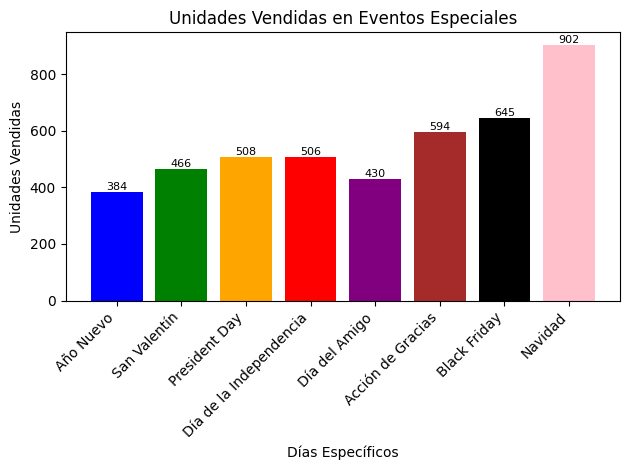

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Lista de fechas específicas
fechas_especificas = ['01-01', '14-02', '18-02', '04-07', '04-08', '28-11', '29-11', '25-12']
nombres_dias = ['Año Nuevo', 'San Valentín', 'President Day', 'Día de la Independencia', 'Día del Amigo', 'Acción de Gracias', 'Black Friday', 'Navidad']

# Crear una columna nueva 'Fecha' en formato datetime
for key, value in dataframes.items():
    value['Fecha'] = pd.to_datetime(value['Fecha de Pedido']).dt.strftime('%d-%m')

ventas_fechas_especificas = []  # Filtrar datos para las fechas específicas y calcular el total de unidades vendidas

for fecha in fechas_especificas:
    total_unidades_vendidas = 0

    for key, value in dataframes.items():
        unidades_fecha = value[value['Fecha'] == fecha]['Cantidad Pedida'].sum()
        total_unidades_vendidas += unidades_fecha

    ventas_fechas_especificas.append(total_unidades_vendidas)

# Crear un DataFrame
df_ventas_fechas_especificas = pd.DataFrame({'Fecha': nombres_dias, 'Unidades Vendidas': ventas_fechas_especificas})

# Colores para las barras
colores = ['blue', 'green', 'orange', 'red', 'purple', 'brown', 'black', 'pink']

# Crear un gráfico de barras
fig, ax = plt.subplots()

# Crear barras y agregar etiquetas
bars = ax.bar(df_ventas_fechas_especificas['Fecha'], df_ventas_fechas_especificas['Unidades Vendidas'], color=colores)

# Agregar etiquetas
ax.bar_label(bars, labels=df_ventas_fechas_especificas['Unidades Vendidas'], label_type='edge', color='white', fontsize=8)
ax.bar_label(bars, labels=df_ventas_fechas_especificas['Unidades Vendidas'], color='black', fontsize=8)

ax.set_xlabel('Días Específicos')
ax.set_ylabel('Unidades Vendidas')
ax.set_title('Unidades Vendidas en Eventos Especiales')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

